# Cancer Classification Using Gene Expression
Data: Golub et al, 1999.

## About the Data
gene expression data from patients diagnosed with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).
- 7129 genes in cells from bone marrow and peripheral blood
-  AML and ALL have similar disease progression but differ in treatments, therefore distinction and classification is important.

## Objective
Classifying the two cancers, i.e. AML and ALL, using this gene expression data (**a binary classification problem**).
- Evaluation method: k-fold cross-validation
- Evaluation metric: accuracy

In [26]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Readinh datasets
trainData = pd.read_csv("data_set_ALL_AML_train.csv")
testData = pd.read_csv("data_set_ALL_AML_independent.csv")

print(trainData.shape)
print(testData.shape)

(7129, 78)
(7129, 70)


The training dataset has 78 columns (i.e. samples) whereas the testing has 70 columns. Rows correspond to genes.

In [3]:
trainData.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [4]:
# Cleaning data

# Removing columns with "call.x"
# From training data
colsToRemoveTrain = [cols for cols in trainData if 'call' in cols]
trainData = trainData.drop(colsToRemoveTrain, axis=1)
print(trainData.columns)

# Removing from test data
colsToRemoveTest = [cols for cols in testData if 'call' in cols]
testData = testData.drop(colsToRemoveTest, axis=1)
print(testData.columns)

Index(['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35',
       '36', '37', '38', '28', '29', '30', '31', '32', '33'],
      dtype='object')
Index(['Gene Description', 'Gene Accession Number', '39', '40', '42', '47',
       '48', '49', '41', '43', '44', '45', '46', '70', '71', '72', '68', '69',
       '67', '55', '56', '59', '52', '53', '51', '50', '54', '57', '58', '60',
       '61', '65', '66', '63', '64', '62'],
      dtype='object')


In [5]:
# Since we are classifying patients (i.e. AML versus ALL) and predicting using gene expression,
# We transpose the data
X_train = trainData.transpose()
X_test = testData.transpose()

# Since both gene description and accession are now column-wise,
# setting accessing as columns and removing the gene description
X_train.columns = X_train.iloc[1]
X_train = X_train.iloc[2:].reset_index(drop=True)

X_test.columns = X_test.iloc[1]
X_test = X_test.iloc[2:].reset_index(drop=True)

In [6]:
# Reading in response variable
yData = pd.read_csv("actual.csv")
print(yData.head())
print(yData.shape)

   patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL
(72, 2)


In [8]:
#merging X and y
X_train.shape[0]+X_test.shape[0]

72

In [10]:
# Merging X data by row
mergedX = pd.concat([X_train, X_test], ignore_index=True, axis=0)

# Merging X and Y
mergedXY = pd.concat([mergedX, yData], axis=1)
mergedXY.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,ALL
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,ALL
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,ALL
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,ALL
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,ALL


<Axes: >

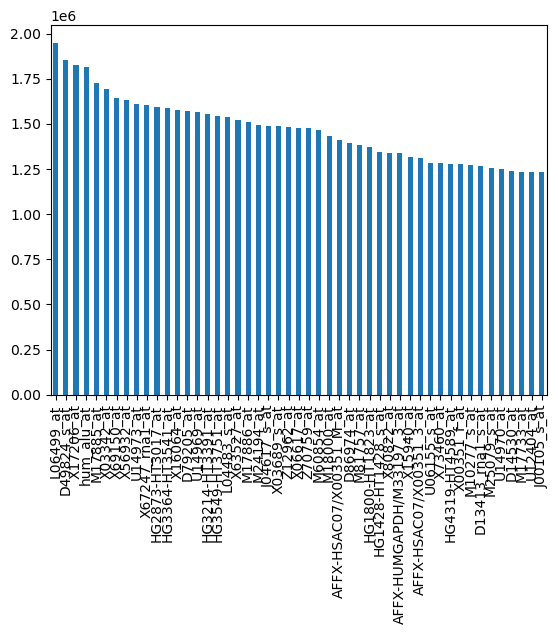

In [11]:
colSum = mergedXY.sum(axis=0)
colSum = colSum[0:len(colSum)-2]

colSum.sort_values(ascending=False, inplace=True)
colSum[0:49].plot(kind='bar')

In [12]:
# Normalizing data
zscaler = StandardScaler()
mergedXY_norm = zscaler.fit_transform(mergedXY.iloc[:, :-2])
mergedXY_norm = pd.DataFrame(mergedXY_norm, columns=mergedXY.columns[:-2])
mergedXY_norm['cancer'] = mergedXY['cancer']
mergedXY_norm

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,-1.024310,0.074633,-0.409794,-0.912181,-0.343639,-1.084633,0.933013,0.148144,1.936296,0.477662,...,-0.518375,-1.304810,0.019140,-0.064488,0.027771,0.122186,0.593119,-0.391378,-0.161117,ALL
1,-0.251570,0.912622,0.058021,0.842926,-0.088142,-0.025964,-0.938122,0.228796,0.235584,-0.107200,...,0.555431,-0.279396,0.160143,0.322438,0.003223,-0.043618,0.032103,-0.576990,0.415146,ALL
2,0.397532,1.164019,-2.453409,1.076941,-1.011228,-1.701073,0.345851,-1.777443,1.418198,-1.387695,...,1.747818,0.515587,-0.568816,1.657332,0.797680,2.306901,0.705322,-0.331659,-0.261337,ALL
3,-0.210357,0.483153,2.241159,-1.596222,-1.365627,-1.265545,0.787991,-0.628140,-0.350091,-0.297724,...,0.548844,2.647065,-0.552853,-1.476766,-0.342677,-0.653193,-1.336776,-0.496289,-1.514082,ALL
4,0.088436,0.367929,-0.557526,-0.192137,0.192081,0.751286,0.243275,0.692550,-0.113568,0.681478,...,-0.063819,0.792103,0.325090,0.148322,-1.183998,0.049037,0.099424,-0.609271,0.139542,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.541777,-0.396735,0.025192,-0.435152,-0.022207,1.273920,-0.824934,-0.275284,-1.059660,0.008000,...,-0.449204,-0.256353,-0.379925,-0.857685,-0.164148,0.244101,-0.708438,-0.280010,0.891189,ALL
68,0.582989,-0.595758,0.583287,-0.849177,0.513512,1.113110,-0.075065,0.390102,-0.969556,-1.538341,...,-1.223267,0.550152,-0.063333,0.690017,-0.797928,-1.282274,-0.214744,2.168460,-0.461776,ALL
69,-0.478240,-0.574808,-0.311307,-0.390149,0.670107,-1.339250,-0.202402,-1.515321,1.023993,-1.086402,...,-0.096758,-0.175703,0.442150,-0.103180,0.063477,0.687871,-0.259626,-0.360711,1.166793,ALL
70,0.686021,-3.884863,-0.951475,2.175008,-2.000248,-2.009293,-3.442400,-2.523482,1.744825,0.260554,...,1.556772,-1.258724,-0.491663,-1.438074,-0.701968,0.219718,-0.214744,-0.241274,-1.063094,ALL


In [61]:
# Splitting data into train and test
#X_train, X_test, y_train, y_test = train_test_split(mergedXY_norm.iloc[:,:-1],
#                                                    mergedXY_norm['cancer'],
#                                                    test_size=0.2, 
#                                                    random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)


## Spot Checking
I will be spot-checking the following machine learning algorithms:
1. Random Forest
2. Logistic Regression
3. K-Nearest Neighbours (KNN)
4. Linear Discriminant Analysis (LDA)
5. Support vector machine (SVM)
6. Classification And Regression Trees (CART)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold, cross_val_score
from matplotlib import pyplot
import random

In [110]:
# Splitting features versus target variables
X = mergedXY_norm.iloc[:,0:mergedXY_norm.shape[1]-2]
y = mergedXY_norm['cancer']

In [42]:
# Define models
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))

In [59]:
# Performing 10-fold cross validation on all models
# And calculating accuracy scores
random.seed()

results = []
names = []

for name, model in models:
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold)
    results.append(scores)
    names.append(name)
    print(f"Average accuracy for {name}:, {scores.mean()}")

Average accuracy for LR:, 0.5232142857142856
Average accuracy for LDA:, 0.7767857142857142
Average accuracy for KNN:, 0.6928571428571428
Average accuracy for CART:, 0.6571428571428571
Average accuracy for SVM:, 0.7642857142857143
Average accuracy for Random Forest:, 0.775


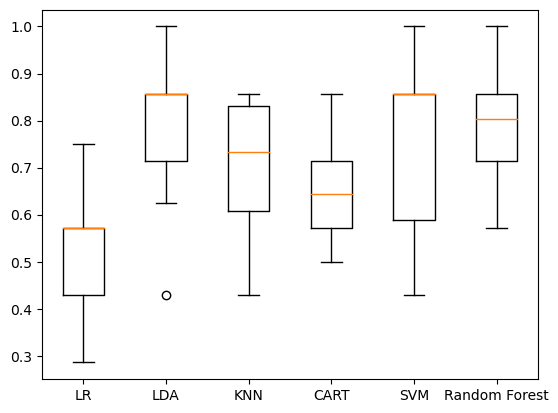

In [60]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

From the boxplot, **LDA**, **SVM** and **Random Forest** does the best and very similar to each other.

## Random Forest Classification of AML and ALL
Performing classification of the two cancer types using random forest and the **entire dataset**.
- Evaluation method: k-fold cross-validation
- Evaluation metric: accuracy

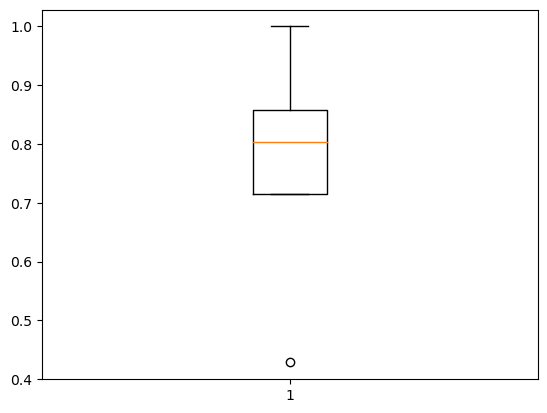

Mean result: 80.53571428571429
Std.Dev of results: 14.473101369965807


In [67]:
kfold_randfor = KFold(n_splits = 10, shuffle=True, random_state = 5)

randomForest = RandomForestClassifier()
results_randfor = cross_val_score(randomForest, X, y, cv=kfold_randfor)

fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results_randfor)
pyplot.show()

print('Mean result:', results.mean()*100)
print('Std.Dev of results:', results.std()*100)

### Perform Feature Selection
Feature selection was performed in order to:
- Reduce dimensionality
- Prevent overfitting the data
- Tune and improve model perform
#### Using sklearn

In [72]:
randomForest.fit(X, y)
featureImportance = randomForest.feature_importances_

# Select the top N most important features
N = 50  # Select top 50 genes
topFeatures = np.argsort(featureImportance)[::-1][:N]
topFeatures
X_selected = X.iloc[:, topFeatures]
X_selected

array([3251, 3560, 2019, 1881, 1259, 3800, 2055, 3020, 5894, 6217, 5388,
       5764, 6920, 6353, 1925, 5572, 4754,  172, 2237, 4405, 2287,  996,
       3300, 2767, 5038, 6475, 4709, 1013,  921, 1132, 3772, 1927, 2666,
       3062, 1538, 6515, 4425, 4471, 4063, 1269, 2355, 6280, 2062, 4489,
       4196, 2093, 2688, 4035, 2241, 1597])

#### Using T-test

In [129]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [115]:
ALL = X[mergedXY_norm['cancer'] == "ALL"]
AML = X[mergedXY_norm['cancer'] == "AML"]

In [139]:
resultsTTest = []

for gene in ALL.columns:
    t_stat, p_val = ttest_ind(ALL[gene], AML[gene], equal_var=False)  # Perform t-test
    resultsTTest.append((gene, t_stat, p_val))
    
dfResults = pd.DataFrame(resultsTTest, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# correcting for multiple testing
sig, adj_p_values = fdrcorrection(dfResults['P_Value'])
print(rejected)
sigGenes = dfResults[sig & (adj_p_values < 0.05)]
sigGenes = sigGenes.sort_values(by='P_Value')
sigGenes

[False False False ... False False False]


,Gene Accession Number,T_Value,P_Value
3300,U49248_at,5.074976,0.000004
4534,X74262_at,4.800367,0.000009
5253,D38073_at,4.759275,0.000010
5351,M69181_at,4.597115,0.000022
1305,L13278_at,4.549869,0.000022
4195,X17042_at,-4.746617,0.000037
378,D32050_at,4.357197,0.000045
531,D63874_at,4.306755,0.000054
4660,X81372_at,4.294243,0.000057
2640,U05237_at,4.257756,0.000063
